<a href="https://colab.research.google.com/github/ajinkya252005/RUL-Prediction-PdM/blob/main/RUL_Prediction_PdM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Maintenance: Remaining Useful Life (RUL) Prediction

This notebook implements a Remaining Useful Life (RUL) prediction model, forming the second pillar of our predictive maintenance framework.

While Anomaly Detection identifies *if* something is wrong, RUL prediction answers *when* it will fail. To do this, we use a Long Short-Term Memory (LSTM) neural network, which is excellent at finding patterns in sequential time-series data.

## Step 1: Environment Setup & Data Loading
We will use the **NASA C-MAPSS Turbofan Engine Degradation dataset**. This dataset contains run-to-failure sensor data for multiple aircraft engines.
- **engine_id:** The specific engine being monitored.
- **cycle:** The time step (each cycle represents a flight).
- **sensors:** 21 different temperature, pressure, and speed sensors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Download the dataset from a reliable GitHub mirror
!git clone https://github.com/NeethuNazar/EE475Dataset.git

# 2. Define the column names based on the NASA documentation
# Columns: Engine ID, Cycle (Time), 3 Operating Settings, 21 Sensor Measurements
cols = ['engine_id', 'cycle', 'setting_1', 'setting_2', 'setting_3'] + [f'sensor_{i}' for i in range(1, 22)]

# 3. Load the training dataset (FD001 - standard operating conditions)
train_df = pd.read_csv('EE475Dataset/CMaps/train_FD001.txt', sep='\s+', header=None, names=cols)

# 4. Load the test dataset and the ground truth (actual RUL) for later evaluation
test_df = pd.read_csv('EE475Dataset/CMaps/test_FD001.txt', sep='\s+', header=None, names=cols)
truth_df = pd.read_csv('EE475Dataset/CMaps/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

print("✅ NASA C-MAPSS Datasets loaded successfully!\n")
print(f"--- Training Data Shape: {train_df.shape} ---")
display(train_df.head())

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3512840659.py:13: SyntaxWarning: invalid escape sequence '\s'
  train_df = pd.read_csv('EE475Dataset/CMaps/train_FD001.txt', sep='\s+', header=None, names=cols)
/tmp/ipython-input-3512840659.py:16: SyntaxWarning: invalid escape sequence '\s'
  test_df = pd.read_csv('EE475Dataset/CMaps/test_FD001.txt', sep='\s+', header=None, names=cols)
/tmp/ipython-input-3512840659.py:17: SyntaxWarning: invalid escape sequence '\s'
  truth_df = pd.read_csv('EE475Dataset/CMaps/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])


Cloning into 'EE475Dataset'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 1), reused 15 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 11.57 MiB | 17.07 MiB/s, done.
Resolving deltas: 100% (1/1), done.
✅ NASA C-MAPSS Datasets loaded successfully!

--- Training Data Shape: (20631, 26) ---


,engine_id,cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Step 2: Calculating the RUL (Target Variable)

For the training data, every engine is run until it completely fails. Therefore, the maximum cycle recorded for a specific engine is its failure point.

To calculate the Remaining Useful Life (RUL) for any given row, we simply find the maximum cycle for that engine and subtract the current cycle:
`RUL = Max_Cycle - Current_Cycle`

This creates a linear degradation curve (countdown) that our LSTM will learn to predict.

✅ RUL calculation complete!


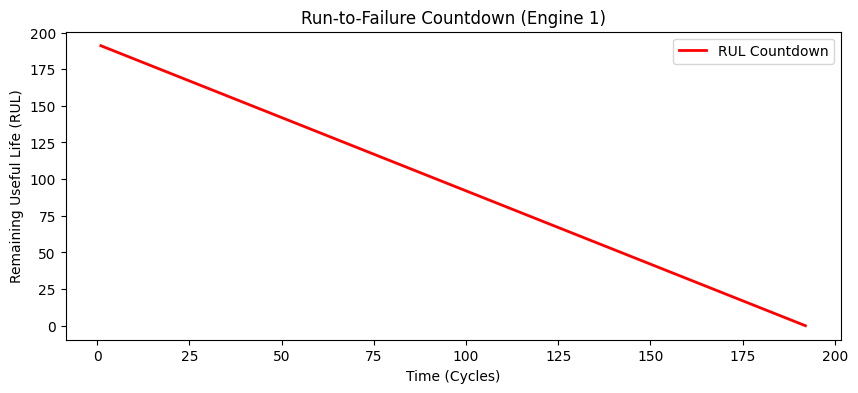

,engine_id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [2]:
# 1. Find the maximum cycle (failure point) for each engine
max_cycles = train_df.groupby('engine_id')['cycle'].max().reset_index()
max_cycles.columns = ['engine_id', 'max_cycle']

# 2. Merge this maximum cycle back into the original training dataframe
train_df = pd.merge(train_df, max_cycles, on='engine_id')

# 3. Calculate the RUL: (Maximum Cycle - Current Cycle)
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

# 4. Drop the 'max_cycle' column as we only needed it for the calculation
train_df.drop('max_cycle', axis=1, inplace=True)

print("✅ RUL calculation complete!")

# Let's visualize the RUL countdown for the very first engine (Engine ID: 1)
plt.figure(figsize=(10, 4))
engine_1_data = train_df[train_df['engine_id'] == 1]
plt.plot(engine_1_data['cycle'], engine_1_data['RUL'], label='RUL Countdown', color='red', linewidth=2)
plt.title('Run-to-Failure Countdown (Engine 1)')
plt.xlabel('Time (Cycles)')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.show()

# Display the updated dataframe
display(train_df[['engine_id', 'cycle', 'RUL']].head())

## Step 3: Data Preprocessing & Scaling

Neural networks are sensitive to the scale of input data. If one sensor has values in the 1000s and another has values in the 0.01s, the network might unfairly prioritize the larger numbers.

To fix this, we will use **MinMaxScaler** to squeeze all our sensor readings and operational settings into a standard range between `0` and `1`.
*Note: We only scale the features (settings and sensors). We do not scale our identifiers (`engine_id`, `cycle`) or our target (`RUL`).*

In [3]:
from sklearn.preprocessing import MinMaxScaler

# 1. Define the columns we want to scale
# These are the 3 settings and the 21 sensors
features_to_scale = ['setting_1', 'setting_2', 'setting_3'] + [f'sensor_{i}' for i in range(1, 22)]

# 2. Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# 3. Fit the scaler to the training data and transform it
# We replace the original columns with the scaled values
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

print("✅ Data successfully scaled to a range of 0 to 1!")

# Let's verify by looking at the maximum and minimum values of the first few sensors
print("\n--- Quick Sanity Check (Min and Max should be 0 and 1) ---")
display(train_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4']].describe().loc[['min', 'max']])

# Display the updated dataframe
print("\n--- Scaled Training Data ---")
display(train_df.head(3))

✅ Data successfully scaled to a range of 0 to 1!

--- Quick Sanity Check (Min and Max should be 0 and 1) ---


,sensor_1,sensor_2,sensor_3,sensor_4
min,0.0,0.0,0.0,0.0
max,0.0,1.0,1.0,1.0



--- Scaled Training Data ---


,engine_id,cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189


## Step 4: Creating Time-Series Sequences (Sliding Window)

LSTMs require input data to be in a 3D format: `[samples, time_steps, features]`.
We will use a **sliding window** approach. If we set our `sequence_length` to 50, the model will look at 50 consecutive cycles to make a single RUL prediction.

We will slide this window down the timeline of each engine, creating overlapping blocks of 50 cycles.
- **X (Input):** A block of 50 cycles of sensor data.
- **Y (Target):** The actual RUL at the *very last cycle* of that 50-cycle block.

In [4]:
# 1. Define the sequence length (how many cycles the LSTM looks back)
sequence_length = 50

# Function to generate sequences for a single engine
def generate_sequences(df, seq_length, feature_cols):
    X, y = [], []
    # Convert dataframe to numpy array for faster processing
    data = df[feature_cols].values
    targets = df['RUL'].values

    # Slide the window across the data
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(targets[i + seq_length - 1]) # The RUL at the end of the window

    return np.array(X), np.array(y)

# 2. Process all engines and combine the sequences
X_train_seq, y_train_seq = [], []

# Loop through each unique engine ID
for engine_id in train_df['engine_id'].unique():
    engine_data = train_df[train_df['engine_id'] == engine_id]

    # We can only create sequences if the engine has more cycles than our sequence length
    if len(engine_data) >= sequence_length:
        X_seq, y_seq = generate_sequences(engine_data, sequence_length, features_to_scale)
        X_train_seq.append(X_seq)
        y_train_seq.append(y_seq)

# 3. Concatenate all engines' data together
X_train = np.concatenate(X_train_seq)
y_train = np.concatenate(y_train_seq)

print("✅ Sequences generated successfully!")
print(f"--- Input Shape (X): {X_train.shape} ---")
print(f"Meaning: {X_train.shape[0]} samples, {X_train.shape[1]} time steps, {X_train.shape[2]} features.")
print(f"--- Target Shape (y): {y_train.shape} ---")

✅ Sequences generated successfully!
--- Input Shape (X): (15631, 50, 24) ---
Meaning: 15631 samples, 50 time steps, 24 features.
--- Target Shape (y): (15631,) ---


## Step 5: Building and Training the LSTM Model

We will build a Deep LSTM network using TensorFlow/Keras.
1. **LSTM Layers:** We use two LSTM layers to learn the complex, hidden patterns in how the sensors degrade over time.
2. **Dropout:** We add Dropout layers to randomly turn off neurons during training. This forces the model to learn robust features and prevents it from simply memorizing the training data (overfitting).
3. **Output Layer:** A single Dense neuron with a linear activation function, because we are predicting a single continuous number (the RUL).
4. **Compilation:** We optimize using 'adam' and measure our error using Mean Squared Error (MSE).


--- LSTM Model Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "RUL_Prediction_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer_1 (LSTM)             │ (None, 50, 64)         │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_2 (LSTM)             │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,233 (137.63 KB)

 Trainable params: 35,233 (137.63 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Starting Training...
Epoch 1/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 9432.2422 - mae: 79.0670 - val_loss: 11194.1152 - val_mae: 84.2365
Epoch 2/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 7876.7700 - mae: 70.2900 - val_loss: 10072.0752 - val_mae: 78.5401
Epoch 3/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 7007.7539 - mae: 65.1524 - val_loss: 9118.3584 - val_mae: 73.7573
Epoch 4/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 6228.4204 - mae: 60.7718 - val_loss: 8299.0137 - val_mae: 69.7076
Epoch 5/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 5556.9297 - mae: 56.8552 - val_loss: 7594.8594 - val_mae: 66.2822
Epoch 6/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 5016.8677 - mae: 53.8195 - val_loss: 6993.6631 - val_mae: 63.4145
Epoch 7/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 4828.3301 - mae: 52.7516 - val_loss: 6487.3677 - val_mae: 61.0511
Epoch 8/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 4326.2524 - mae: 50

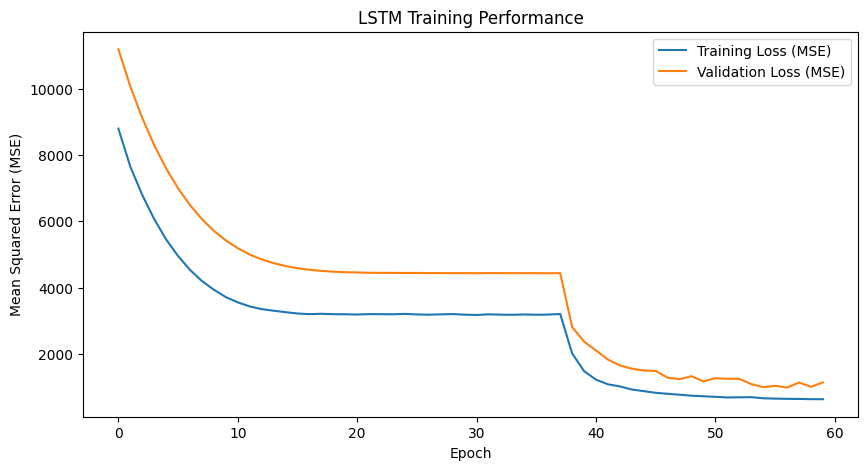

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Get the exact shape of our input data
# X_train.shape[1] is the sequence length (50), X_train.shape[2] is the number of features (24)
input_shape = (X_train.shape[1], X_train.shape[2])

# 2. Build the LSTM Architecture
model = Sequential(name="RUL_Prediction_LSTM")

# First LSTM Layer
model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape, name="LSTM_Layer_1"))
model.add(Dropout(0.2, name="Dropout_1"))

# Second LSTM Layer
model.add(LSTM(units=32, return_sequences=False, name="LSTM_Layer_2"))
model.add(Dropout(0.2, name="Dropout_2"))

# Output Layer (Predicting a single continuous value)
model.add(Dense(units=1, activation='linear', name="Output_Layer"))

# 3. Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print("\n--- LSTM Model Summary ---")
model.summary()

# 4. Define Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 5. Train the Model
print("\n🚀 Starting Training...")
history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=64,
    validation_split=0.1,    # Use 10% of training data to validate
    callbacks=[early_stopping],
    verbose=1
)
print("✅ Training complete!")

# 6. Plot the Training History
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('LSTM Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

## Step 6: Evaluating the LSTM on Unseen Test Data

To test our model, we need to prepare the test data:
1. **Scale:** We scale the test data using the *exact same scaler* we fitted on the training data.
2. **Extract Last Sequence:** Since we only want to predict the RUL at the very end of the test engine's recorded life, we only extract the last 50 cycles for each test engine.
3. **Predict & Compare:** We make our predictions and calculate the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) against the actual ground truth.
4. **Visualize:** We plot the Predicted RUL vs. the Actual RUL to see how close we are!

✅ Test Sequences Ready! Shape: (100, 50, 24)
Predicting RUL...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step

--- LSTM Performance on Test Data ---
Root Mean Squared Error (RMSE): 23.46 cycles
Mean Absolute Error (MAE):      16.21 cycles



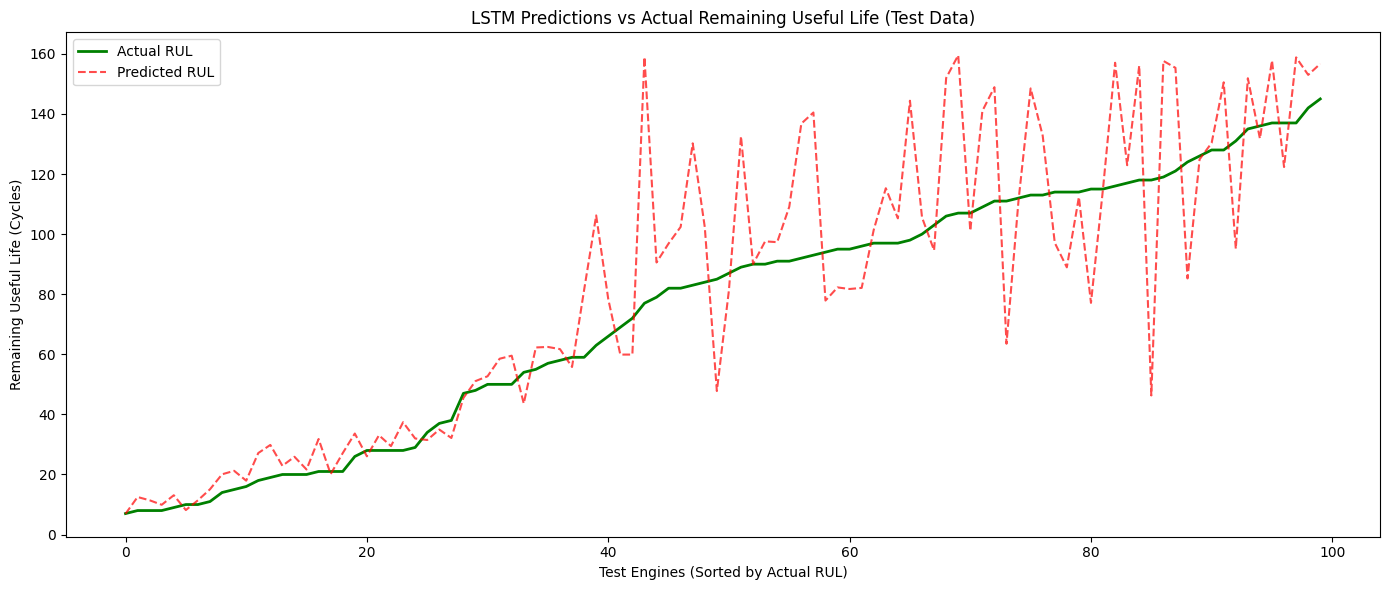

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Scale the test data using the already fitted scaler
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

# 2. Extract the last sequence (50 cycles) for each engine
X_test_seq = []
engine_ids = test_df['engine_id'].unique()

for engine_id in engine_ids:
    engine_data = test_df[test_df['engine_id'] == engine_id]

    # Check if the engine has enough cycles for our sequence length
    if len(engine_data) >= sequence_length:
        # Grab the very last 50 rows of feature data
        last_seq = engine_data[features_to_scale].values[-sequence_length:]
        X_test_seq.append(last_seq)
    else:
        # If an engine has fewer than 50 cycles, we pad the beginning with zeros
        pad_length = sequence_length - len(engine_data)
        padded_seq = np.pad(engine_data[features_to_scale].values,
                            ((pad_length, 0), (0, 0)),
                            'constant', constant_values=0)
        X_test_seq.append(padded_seq)

X_test = np.array(X_test_seq)
print(f"✅ Test Sequences Ready! Shape: {X_test.shape}")

# 3. Predict the RUL for the Test Engines
print("Predicting RUL...")
y_pred = model.predict(X_test)

# 4. Get the Actual Ground Truth RUL
y_true = truth_df['RUL'].values

# 5. Calculate Error Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print("\n--- LSTM Performance on Test Data ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} cycles")
print(f"Mean Absolute Error (MAE):      {mae:.2f} cycles\n")

# 6. Plot Predicted vs Actual RUL
plt.figure(figsize=(14, 6))
# Sort the values by actual RUL for a cleaner line plot
indices = np.argsort(y_true)

plt.plot(y_true[indices], label='Actual RUL', color='green', linewidth=2)
plt.plot(y_pred[indices], label='Predicted RUL', color='red', alpha=0.7, linestyle='--')

plt.title('LSTM Predictions vs Actual Remaining Useful Life (Test Data)')
plt.xlabel('Test Engines (Sorted by Actual RUL)')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.legend()
plt.tight_layout()
plt.show()